##### Copyright 2020 The TensorFlow Authors.

In [3]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

## Setup

Import necessary modules and dependencies. You'll be using `tf.keras.utils.audio_dataset_from_directory` (introduced in TensorFlow 2.10), which helps generate audio classification datasets from directories of `.wav` files. You'll also need [seaborn](https://seaborn.pydata.org) for visualization in this tutorial.

In [1]:
!pip install -U -q tensorflow==2.16.1  tensorflow_datasets

In [2]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

## Import the Speech Commands dataset

This is the [dataset](https://dax-cdn.cdn.appdomain.cloud/dax-tensorflow-speech-commands/1.0.1/data_preview/index.html) that you will be working on. This dataset consists of 65,000 WAV Files and the audio clips were originally collected by Google, and recorded by volunteers in uncontrolled locations around the world.

In [3]:
DATASET_PATH = '/kaggle/input/tvd-2024-reconocimiento-de-comandos-de-voz/train/train/audio'

data_dir = pathlib.Path(DATASET_PATH)

The dataset's audio clips are stored in 31 folders corresponding to each speech command. 

- 20 core words: `yes`, `no`, `up`, `down`, `left`,`right`, `on`, `off`, `stop`, `go`, `zero`, `one`,`two`, `three`, `four`, `five`,`six`, `seven`, `eight`, `nine`,   

- 10 auxiliary words: `bed`, `bird`, `cat`, `dog`, `happy`, `house`, `marvin`, `sheila`, `tree` and `wow`
  
- And background noise: `doing_the_dishes`, `dude_miaowing`, `exercise_bike`, `pink_noise`, `running_tap`, and `white_noise`.

In [4]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[(commands != 'README.md') & (commands != '.DS_Store')]
print('Commands:', commands)

Commands: ['no' 'two' 'four' 'five' 'nine' 'right' '_background_noise_' 'off' 'yes'
 'six' 'dog' 'left' 'bird' 'wow' 'zero' 'eight' 'bed' 'go' 'house' 'tree'
 'seven' 'on' 'three' 'one' 'down' 'stop' 'up' 'happy' 'marvin' 'cat'
 'sheila']


Divided into directories this way, you can easily load the data using `keras.utils.audio_dataset_from_directory`.

The audio clips are 1 second or less at 16kHz. The `output_sequence_length=16000` pads the short ones to exactly 1 second (and would trim longer ones) so that they can be easily batched.

In [5]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 64727 files belonging to 31 classes.
Using 51782 files for training.
Using 12945 files for validation.

label names: ['_background_noise_' 'bed' 'bird' 'cat' 'dog' 'down' 'eight' 'five'
 'four' 'go' 'happy' 'house' 'left' 'marvin' 'nine' 'no' 'off' 'on' 'one'
 'right' 'seven' 'sheila' 'six' 'stop' 'three' 'tree' 'two' 'up' 'wow'
 'yes' 'zero']


The dataset now contains batches of audio clips and integer labels. The audio clips have a shape of `(batch, samples, channels)`.

In [6]:
train_ds.element_spec

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

This dataset only contains single channel audio, so use the `tf.squeeze` function to drop the extra axis:

In [7]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

The `utils.audio_dataset_from_directory` function only returns up to two splits. It's a good idea to keep a test set separate from your validation set.
Ideally you'd keep it in a separate directory, but in this case you can use `Dataset.shard` to split the validation set into two halves. Note that iterating over **any** shard will load **all** the data, and only keep its fraction.

In [8]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [9]:
for example_audio, example_labels in train_ds.take(1):
  print(example_audio.shape)
  print(example_labels.shape)

(64, 16000)
(64,)


Let's plot a few audio waveforms:

In [10]:
label_names[[1,1,3,0]]

array(['bed', 'bed', 'cat', '_background_noise_'], dtype='<U18')

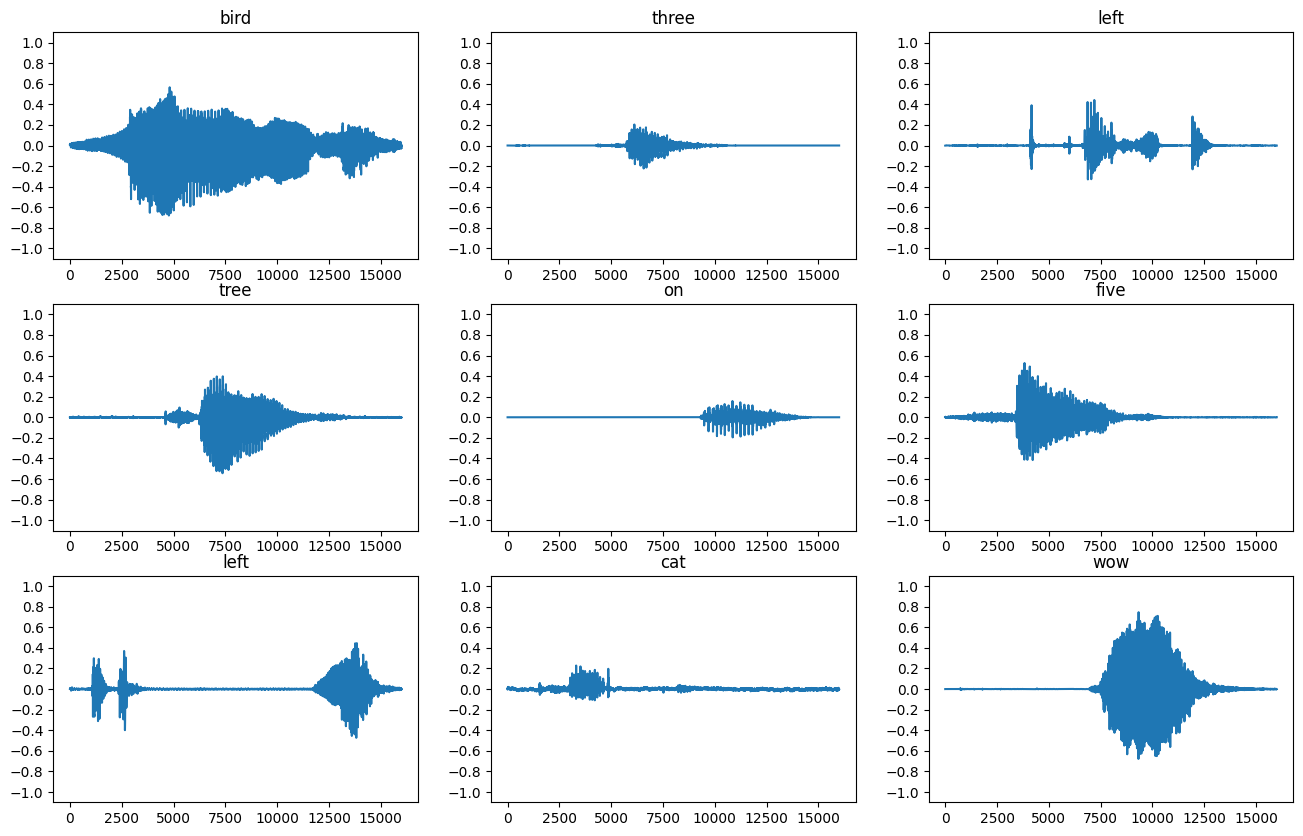

In [11]:
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = example_audio[i]
  plt.plot(audio_signal)
  plt.title(label_names[example_labels[i]])
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-1.1, 1.1])

## Convert waveforms to spectrograms

The waveforms in the dataset are represented in the time domain. Next, you'll transform the waveforms from the time-domain signals into the time-frequency-domain signals by computing the [short-time Fourier transform (STFT)](https://en.wikipedia.org/wiki/Short-time_Fourier_transform) to convert the waveforms to as [spectrograms](https://en.wikipedia.org/wiki/Spectrogram), which show frequency changes over time and can be represented as 2D images. You will feed the spectrogram images into your neural network to train the model.

A Fourier transform (`tf.signal.fft`) converts a signal to its component frequencies, but loses all time information. In comparison, STFT (`tf.signal.stft`) splits the signal into windows of time and runs a Fourier transform on each window, preserving some time information, and returning a 2D tensor that you can run standard convolutions on.

Create a utility function for converting waveforms to spectrograms:

- The waveforms need to be of the same length, so that when you convert them to spectrograms, the results have similar dimensions. This can be done by simply zero-padding the audio clips that are shorter than one second (using `tf.zeros`).
- When calling `tf.signal.stft`, choose the `frame_length` and `frame_step` parameters such that the generated spectrogram "image" is almost square. For more information on the STFT parameters choice, refer to [this Coursera video](https://www.coursera.org/lecture/audio-signal-processing/stft-2-tjEQe) on audio signal processing and STFT.
- The STFT produces an array of complex numbers representing magnitude and phase. However, in this tutorial you'll only use the magnitude, which you can derive by applying `tf.abs` on the output of `tf.signal.stft`.

In [12]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram


def get_mel_spectrogram(waveform, num_mel_bins=128):
    # Compute the STFT.
    spectrogram = tf.signal.stft(
        waveform, frame_length=255, frame_step=128
    )
    spectrogram = tf.abs(spectrogram)

    num_spectrogram_bins = spectrogram.shape[-1]

    
    linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
        num_mel_bins=num_mel_bins,
        num_spectrogram_bins=num_spectrogram_bins,
        sample_rate=16000,
        lower_edge_hertz=80.0, 
        upper_edge_hertz=8000.0)

    mel_spectrogram = tf.matmul(spectrogram, linear_to_mel_weight_matrix)
    mel_spectrogram = tf.math.log1p(mel_spectrogram)

    mel_spectrogram = mel_spectrogram[..., tf.newaxis]
    
    return mel_spectrogram

def get_mfcc(waveform, num_mel_bins=128, num_mfccs=13):
    log_mel_spectrogram = get_mel_spectrogram(waveform, num_mel_bins)
    
    mfccs = tf.signal.mfccs_from_log_mel_spectrograms(tf.squeeze(log_mel_spectrogram, axis=-1))

    mfccs = mfccs[..., :num_mfccs]  # Select the desired number of MFCCs
    mfccs = mfccs[..., tf.newaxis]
    return mfccs

def get_power_spectrogram(waveform):
    # Compute the STFT
    spectrogram = tf.signal.stft(waveform, frame_length=255, frame_step=128)
    # Compute the power spectrogram (squared magnitude)
    power_spectrogram = tf.square(tf.abs(spectrogram))
    power_spectrogram = power_spectrogram[..., tf.newaxis]
    return power_spectrogram



Next, start exploring the data. Print the shapes of one example's tensorized waveform and the corresponding spectrogram, and play the original audio:

In [13]:
for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Label: bird
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: three
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: left
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Now, define a function for displaying a spectrogram:

In [14]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

Plot the example's waveform over time and the corresponding spectrogram (frequencies over time):

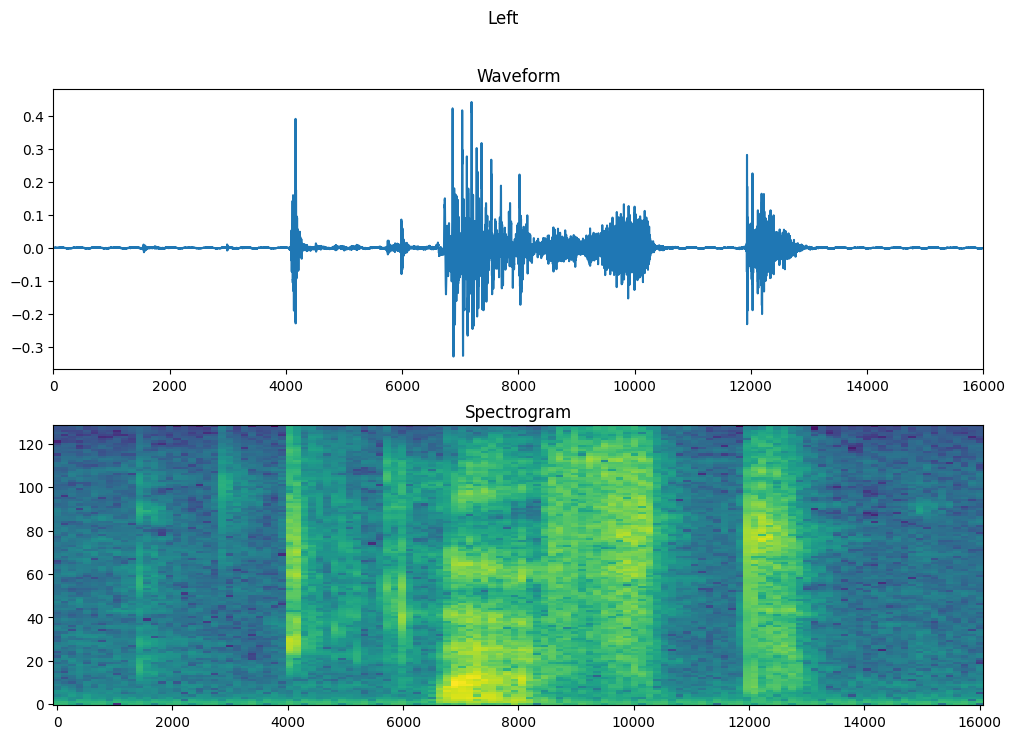

In [15]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

Now, create spectrogram datasets from the audio datasets:

In [16]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)


def make_mel_ds(ds, bins=128):
  return ds.map(
      map_func=lambda audio,label: (get_mel_spectrogram(audio, bins), label),
      num_parallel_calls=tf.data.AUTOTUNE)

def make_mfcc_ds(ds, bins=128, mfcss=13):
  return ds.map(
      map_func=lambda audio,label: (get_mfcc(audio, bins, mfcss), label),
      num_parallel_calls=tf.data.AUTOTUNE)

def make_power_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_power_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

    

In [17]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

Examine the spectrograms for different examples of the dataset:

In [18]:
spectrogram_datasets = {
    'spectrogram': {
        'train': make_spec_ds(train_ds),
        'val': make_spec_ds(val_ds),
        'test': make_spec_ds(test_ds)
    },
    'mel_spectrogram_64': {
        'train': make_mel_ds(train_ds, bins=64),
        'val': make_mel_ds(val_ds, bins=64),
        'test': make_mel_ds(test_ds, bins=64)
    },
    'mel_spectrogram_128': {
        'train': make_mel_ds(train_ds, bins=128),
        'val': make_mel_ds(val_ds, bins=128),
        'test': make_mel_ds(test_ds, bins=128)
    },
    'mfcc_64': {
        'train': make_mfcc_ds(train_ds, mfcss=64),
        'val': make_mfcc_ds(val_ds, mfcss=64),
        'test': make_mfcc_ds(test_ds, mfcss=64)
    }
}

## Build and train the model

In [29]:
train_spectrogram_ds = spectrogram_datasets['mel_spectrogram_64']['train']
val_spectrogram_ds = spectrogram_datasets['mel_spectrogram_64']['val']
test_spectrogram_ds = spectrogram_datasets['mel_spectrogram_64']['test']



In [30]:
train_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [31]:
for example_spectrograms, example_spect_labels in train_ds.take(1):
    break
input_shape = example_spectrograms.shape[1:]
num_labels = len(label_names)  # Assuming you have label_names defined


norm_layer = layers.Normalization()
norm_layer.adapt(train_spectrogram_ds.map(lambda x, _: x))

In [37]:
input_shape

TensorShape([124, 64, 1])

In [62]:
from tensorflow.keras.models import Sequential, Model

In [64]:
def residual_block(x, filters, kernel_size=3, stride=1):
    """A residual block with Layer Normalization."""
    shortcut = x

    # First convolution layer
    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same')(x)
    x = layers.LayerNormalization()(x)
    x = layers.ReLU()(x)

    # Second convolution layer
    x = layers.Conv2D(filters, kernel_size, padding='same')(x)
    x = layers.LayerNormalization()(x)

    # Add shortcut (adjust shortcut if dimensions change)
    if shortcut.shape[-1] != filters or stride != 1:
        shortcut = layers.Conv2D(filters, 1, strides=stride, padding='same')(shortcut)
        shortcut = layers.LayerNormalization()(shortcut)

    x = layers.Add()([x, shortcut])
    x = layers.ReLU()(x)
    return x

def create_resnetv2(input_shape, num_labels, norm_layer, model_params):
    resize_size = model_params.get('resize',32)
    inputs = layers.Input(shape=input_shape)
    x = layers.Resizing(resize_size, resize_size)(inputs)
    x = norm_layer(x)

    x = layers.Conv2D(32, 3, padding='same')(x)
    x = layers.LayerNormalization()(x)
    x = layers.ReLU()(x)


    for i in range(model_params['num_layers']):
        x = residual_block(x, model_params['filters'][i])
        x = layers.MaxPooling2D()(x)


    if model_params.get('joining') == "max_pooling":
        x = layers.GlobalMaxPooling2D()(x)
    elif model_params.get('joining') == "flatten":
        x = layers.Flatten()(x)
    else:
        x = layers.GlobalAveragePooling2D()(x)
    
    x = layers.Dense(model_params['dense_units'], activation='relu')(x)
    outputs = layers.Dense(num_labels)(x)

    return Model(inputs, outputs)

In [65]:
def build_model(model_params):
    model_type = model_params['type']
    resize_size = model_params.get('resize',32)

    if model_type == 'conv2d':
        model = models.Sequential([
            layers.Input(shape=input_shape),
            layers.Resizing(resize_size, resize_size),
            norm_layer
        ])
        for i in range(model_params['num_layers']):
            model.add(layers.Conv2D(
                filters=model_params['filters'][i],
                kernel_size=model_params['kernel_size'][i],
                strides=model_params['strides'][i],
                activation='relu',
                padding='same'
            ))
            if model_params['max_pooling'][i]:
              model.add(layers.MaxPooling2D())
            if model_params.get('normalization'):
              model.add(layers.LayerNormalization())
                
    elif model_type == 'conv1d':
        # Reshape data for 1D convolution (assuming time is the last dimension)
        model = models.Sequential([
            layers.Input(shape=input_shape),
            layers.Resizing(resize_size,resize_size),
            layers.Reshape((resize_size*resize_size, )),
            layers.Lambda(lambda x: tf.expand_dims(x, axis=-1))
        ])

        for i in range(model_params['num_layers']):
          model.add(layers.Conv1D(
              filters=model_params['filters'][i],
              kernel_size=model_params['kernel_size'][i],
              strides=model_params['strides'][i],
              activation='relu',
              padding='same'
          ))
          if model_params.get('normalization'):
            model.add(layers.LayerNormalization())
              
          if model_params['max_pooling'][i]:
            model.add(layers.MaxPooling1D())
          

    elif model_type == 'mixed':
      model = models.Sequential([
          layers.Input(shape=input_shape),
          layers.Resizing(resize_size, resize_size),
          layers.Reshape((resize_size*resize_size, )),
          layers.Lambda(lambda x: tf.expand_dims(x, axis=-1))
      ])
      for i in range(model_params['conv1d_layers']):
        model.add(layers.Conv1D(
            filters=model_params['filters'][i],
            kernel_size=model_params['kernel_size'][i],
            strides=model_params['strides'][i],
            activation='relu',
            padding='same'
        ))
        if model_params['max_pooling'][i]:
          model.add(layers.MaxPooling1D())
      model.add(layers.Reshape((resize_size, resize_size, -1)))
        
      for i in range(model_params['conv1d_layers'],model_params['num_layers']):
        model.add(layers.Conv2D(
            filters=model_params['filters'][i],
            kernel_size=model_params['kernel_size'][i],
            strides=model_params['strides'][i],
            activation='relu',
            padding='same'
        ))
        if model_params.get('normalization'):
            model.add(layers.LayerNormalization())
        if model_params['max_pooling'][i]:
          model.add(layers.MaxPooling2D())
        

    elif model_type == 'resnet': # Res-net style CONV to try residual conections
        inputs = layers.Input(shape=input_shape)
        x = layers.Resizing(resize_size, resize_size)(inputs)
        x = norm_layer(x)

        for i in range(model_params['num_layers']):
            if model_params['residual'][i]:
                residual = x

            x = layers.Conv2D(
                filters=model_params['filters'][i],
                kernel_size=model_params['kernel_size'][i],
                strides=model_params['strides'][i],
                activation='relu',
                padding='same'
            )(x)

            if model_params.get('normalization'):
                x = layers.LayerNormalization()(x)

            if model_params['residual'][i]:
                if residual.shape[-1] != model_params['filters'][i] or model_params['strides'][i] != (1,1):

                  residual = layers.Conv2D(
                      filters=model_params['filters'][i],
                      kernel_size=(1, 1),
                      strides=model_params['strides'][i],
                      padding='same'
                  )(residual)
                  

                x = layers.Add()([x, residual])

            if model_params['max_pooling'][i]:
              x = layers.MaxPooling2D()(x)


        x = layers.Flatten()(x)
        x = layers.Dense(model_params['dense_units'], activation='relu')(x)
        outputs = layers.Dense(num_labels)(x)

    
        model = tf.keras.Model(inputs=inputs, outputs=outputs)
        return model

    elif model_type == 'resnetv2':
        model = create_resnetv2(input_shape, num_labels, norm_layer, model_params)
        return model
    else:
        raise ValueError(f"Invalid model type: {model_type}")


    if model_params.get('joining') == "average_pooling":
        model.add(layers.GlobalAveragePooling2D())
    elif model_params.get('joining') == "max_pooling":
        model.add(layers.GlobalMaxPooling2D())
    else:
        model.add(layers.Flatten())
    model.add(layers.Dense(model_params['dense_units'], activation='relu'))
    model.add(layers.Dense(num_labels))

    return model

Architecture: conv2d_3_avg has 107682 parameters
Test Accuracy for conv2d_3_avg: 0.9230


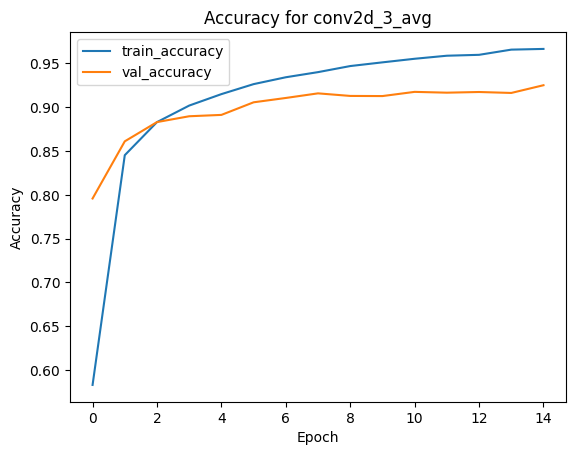

Architecture: conv2d_7_avg has 32706 parameters
Test Accuracy for conv2d_7_avg: 0.9067


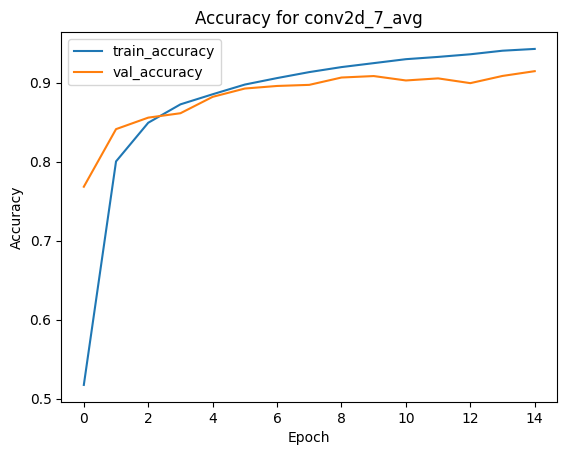

Architecture: conv2d_8_avg has 107426 parameters
Test Accuracy for conv2d_8_avg: 0.9250


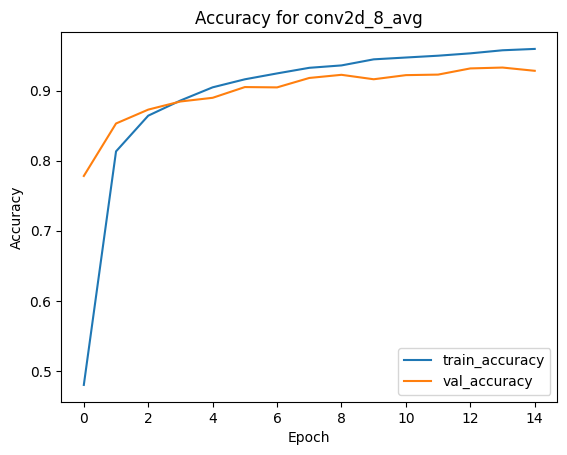

Architecture: conv2d_11_avg has 250530 parameters


I0000 00:00:1735479090.798090     100 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion', 4 bytes spill stores, 12 bytes spill loads

I0000 00:00:1735479094.173130     102 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_6', 4 bytes spill stores, 12 bytes spill loads



Test Accuracy for conv2d_11_avg: 0.9250


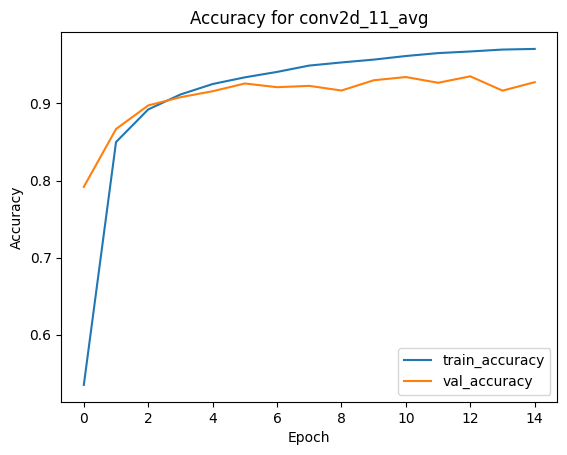

Architecture: conv2d_3_norm has 132738 parameters


I0000 00:00:1735479169.262064     103 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_3', 4 bytes spill stores, 4 bytes spill loads



Test Accuracy for conv2d_3_norm: 0.9198


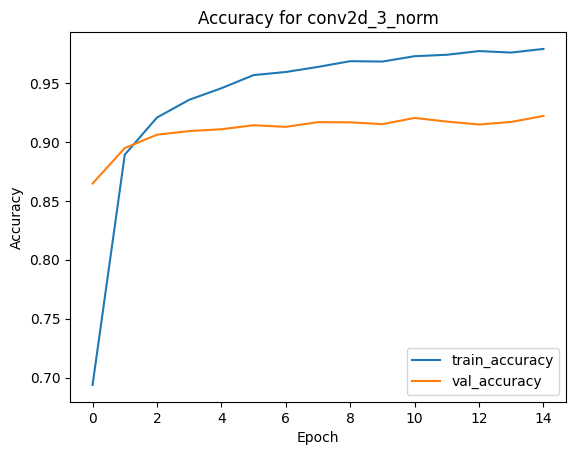

Architecture: conv2d_7_norm has 39106 parameters
Test Accuracy for conv2d_7_norm: 0.9124


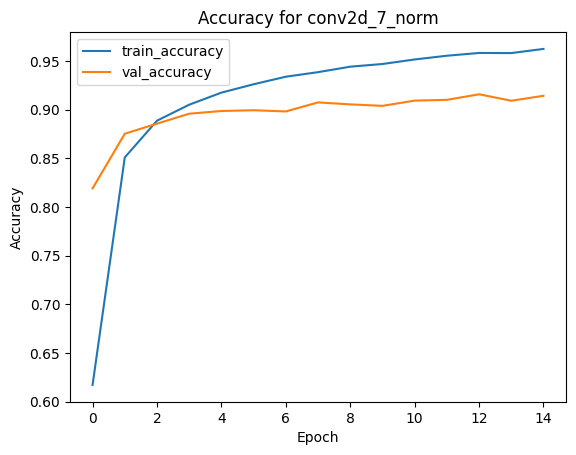

Architecture: conv2d_8_norm has 230786 parameters
Test Accuracy for conv2d_8_norm: 0.9326


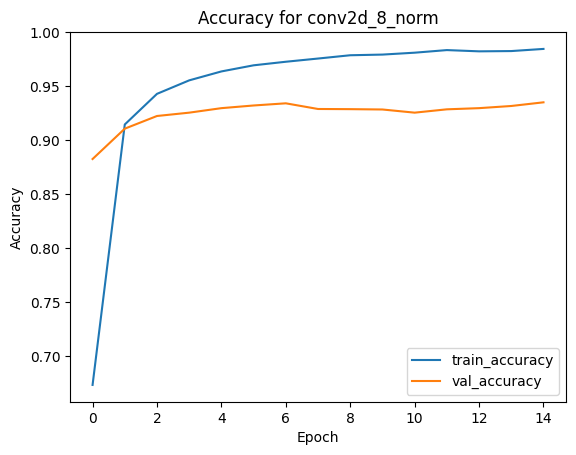

Architecture: conv2d_11_norm has 374114 parameters


I0000 00:00:1735479345.911606     103 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion', 4 bytes spill stores, 12 bytes spill loads

I0000 00:00:1735479349.445582     102 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion', 4 bytes spill stores, 12 bytes spill loads



Test Accuracy for conv2d_11_norm: 0.9397


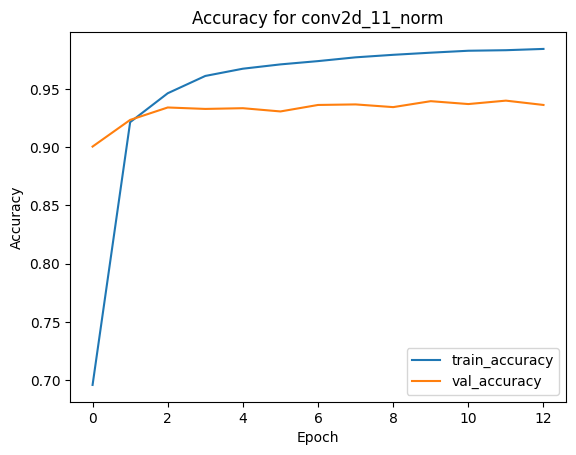

Architecture: resnetv2_1 has 321298 parameters


I0000 00:00:1735479432.005441     102 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_fusion_7', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1735479439.077782     102 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion', 4 bytes spill stores, 12 bytes spill loads



Test Accuracy for resnetv2_1: 0.9499


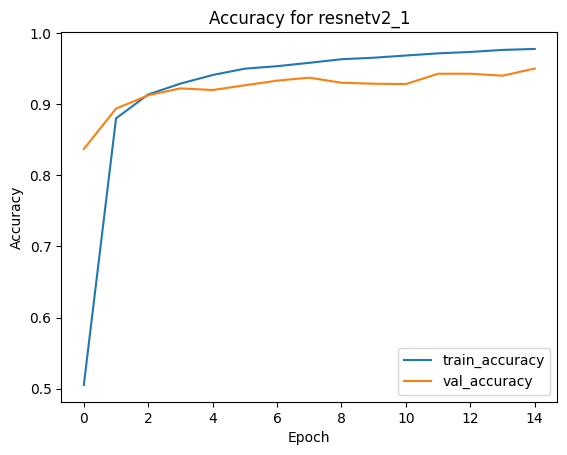

Architecture: resnetv2_2 has 613410 parameters
Test Accuracy for resnetv2_2: 0.9443


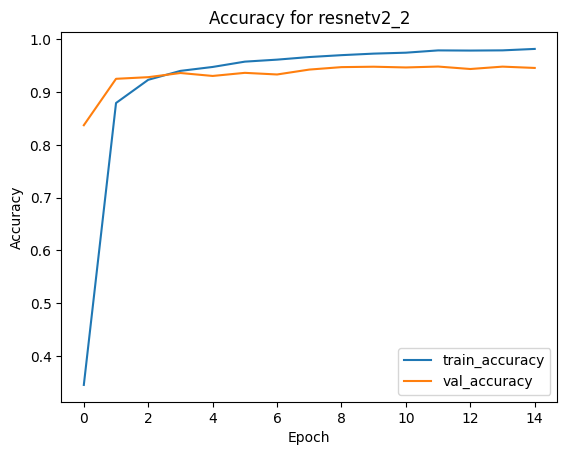

Architecture: resnetv2_3 has 623650 parameters
Test Accuracy for resnetv2_3: 0.9568


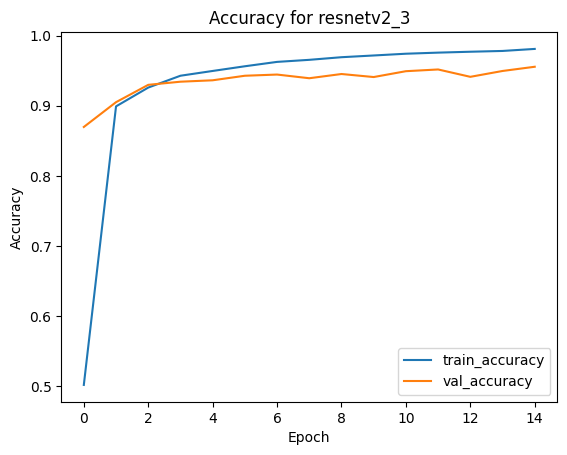

Architecture: resnetv2_4 has 317730 parameters
Test Accuracy for resnetv2_4: 0.9500


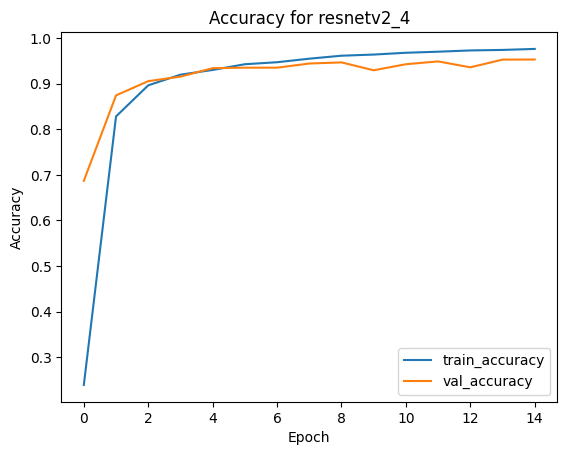

Architecture: resnetv2_5 has 312610 parameters
Test Accuracy for resnetv2_5: 0.0312


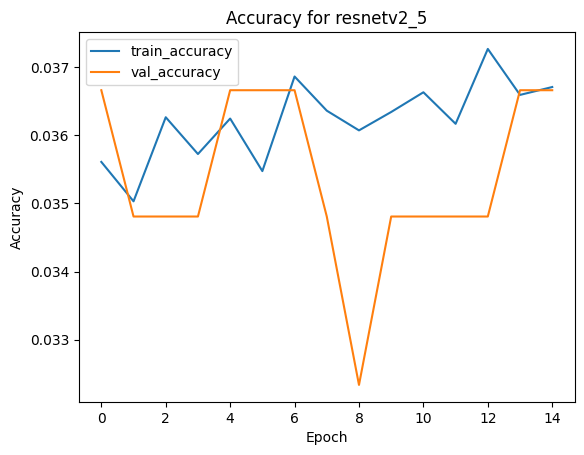

Architecture: resnetv2_6 has 26706 parameters


KeyboardInterrupt: 

In [71]:
def train_model(model, model_name, train_ds, val_ds):
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy'],
    )
    EPOCHS = 15
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
        verbose=0,
        callbacks=tf.keras.callbacks.EarlyStopping(verbose=0, patience=10),
    )
    model.save(f'{model_name}.h5')
    return history

def evaluate_and_plot(model, model_name, history, test_ds):
    loss, accuracy = model.evaluate(test_ds, verbose=0)
    print(f"Test Accuracy for {model_name}: {accuracy:.4f}")

    # Plot accuracy
    plt.figure()
    plt.plot(history.history['accuracy'], label='train_accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.title(f'Accuracy for {model_name}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig(f'{model_name}_accuracy.png')
    plt.show()

    return loss, accuracy
# Define a list of model configurations to try
model_configs = [
    # 1D Convolutional Models
    #{'name': 'conv1d_1', 'type': 'conv1d', 'num_layers': 2, 'filters': [16, 32], 'kernel_size': [5, 3], 'strides': [1, 1],'max_pooling' : [True, True], 'dense_units': 64},
    #{'name': 'conv1d_2', 'type': 'conv1d', 'num_layers': 3, 'filters': [32, 64, 128], 'kernel_size': [7, 5, 3], 'strides': [1, 1, 2],'max_pooling' : [False, True, False], 'dense_units': 128},
    #{'name': 'conv1d_3', 'type': 'conv1d', 'num_layers': 4, 'filters': [16, 32, 64, 32], 'kernel_size': [9, 5, 3, 3], 'strides': [2, 1, 1, 1],'max_pooling' : [True, True, False, True], 'dense_units': 32},
    #{'name': 'conv1d_4', 'type': 'conv1d', 'num_layers': 3, 'filters': [32, 64, 32], 'kernel_size': [3, 5, 3], 'strides': [1, 2, 1],'max_pooling' : [True, False, True], 'dense_units': 128},
    #{'name': 'conv1d_5', 'type': 'conv1d', 'num_layers': 3, 'filters': [16, 64, 16], 'kernel_size': [5, 7, 5], 'strides': [1, 2, 1],'max_pooling' : [False, True, False], 'dense_units': 64},
    # 2D Convolutional Models
    #{'name': 'conv2d_1', 'type': 'conv2d', 'num_layers': 2, 'filters': [16, 32], 'kernel_size': [(3, 3), (3, 3)], 'strides': [(1, 1), (1, 1)], 'max_pooling' : [True, True],'dense_units': 64},
    #{'name': 'conv2d_2', 'type': 'conv2d', 'num_layers': 3, 'filters': [32, 64, 128], 'kernel_size': [(3, 3), (3, 3), (3, 3)], 'strides': [(1, 1), (1, 1), (1, 1)],'max_pooling' : [True, True, False], 'dense_units': 128},
    #{'name': 'conv2d_3', 'type': 'conv2d', 'num_layers': 4, 'filters': [16, 32, 64, 128], 'kernel_size': [(5, 5), (3, 3), (3, 3),(3,3)], 'strides': [(2, 2), (1, 1), (1, 1),(1,1)], 'max_pooling' : [False, True, True, True],'dense_units': 64},


    #{'name': 'conv2d_6', 'type': 'conv2d', 'num_layers': 4, 'filters': [128, 64, 32, 16], 'kernel_size': [(5, 5), (3, 3), (3, 3),(3,3)], 'strides': [(2, 2), (1, 1), (1, 1),(1,1)], 'max_pooling' : [False, True, True, True],'dense_units': 64},
    #{'name': 'conv2d_7', 'type': 'conv2d', 'num_layers': 4, 'filters': [32, 32, 32, 32], 'kernel_size': [(5, 5), (3, 3), (3, 3),(3,3)], 'strides': [(2, 2), (1, 1), (1, 1),(1,1)], 'max_pooling' : [False, True, True, True],'dense_units': 64},
    #{'name': 'conv2d_8', 'type': 'conv2d', 'num_layers': 4, 'filters': [16, 32, 64, 128], 'kernel_size': [(3, 3), (3, 3), (3, 3),(3,3)], 'strides': [(1, 1), (1, 1), (1, 1),(1,1)], 'max_pooling' : [False, True, True, True],'dense_units': 64},
    #{'name': 'conv2d_9', 'type': 'conv2d', 'num_layers': 4, 'filters': [16, 32, 64, 128], 'kernel_size': [(7, 7), (5, 5), (3, 3),(3,3)], 'strides': [(2, 2), (2, 2), (1, 1),(1,1)], 'max_pooling' : [False, True, True, True],'dense_units': 64},
    #{'name': 'conv2d_10', 'type': 'conv2d', 'num_layers': 5, 'filters': [32, 32, 64, 64, 128], 'kernel_size': [(3, 3), (3, 3), (3, 3),(3,3),(3,3)], 'strides': [(1, 1), (1, 1), (1, 1),(1,1),(1,1)], 'max_pooling' : [False, True, True, True, True],'dense_units': 64},
    #{'name': 'conv2d_11', 'type': 'conv2d', 'num_layers': 4, 'filters': [32, 64, 128, 128], 'kernel_size': [(3, 3), (3, 3), (3, 3),(3,3)], 'strides': [(1, 1), (1, 1), (1, 1),(1,1)], 'max_pooling' : [False, True, True, True],'dense_units': 64},
    
    #{'name': 'conv2d_4', 'type': 'conv2d', 'num_layers': 3, 'filters': [32, 64, 32], 'kernel_size': [(3, 3), (3, 3), (3, 3)], 'strides': [(1, 1), (1, 1), (1, 1)],'max_pooling' : [True, True, False], 'dense_units': 128},
    #{'name': 'conv2d_5', 'type': 'conv2d', 'num_layers': 3, 'filters': [16, 64, 16], 'kernel_size': [(3, 3), (5, 5), (3, 3)], 'strides': [(1, 1), (2, 2), (1, 1)],'max_pooling' : [True, False, True], 'dense_units': 128},



    {'name': 'conv2d_3_avg', 'joining':'average_pooling', 'type': 'conv2d', 'num_layers': 4, 'filters': [16, 32, 64, 128], 'kernel_size': [(5, 5), (3, 3), (3, 3),(3,3)], 'strides': [(2, 2), (1, 1), (1, 1),(1,1)], 'max_pooling' : [False, True, True, True],'dense_units': 64},
    {'name': 'conv2d_7_avg', 'joining':'average_pooling', 'type': 'conv2d', 'num_layers': 4, 'filters': [32, 32, 32, 32], 'kernel_size': [(5, 5), (3, 3), (3, 3),(3,3)], 'strides': [(2, 2), (1, 1), (1, 1),(1,1)], 'max_pooling' : [False, True, True, True],'dense_units': 64},
    {'name': 'conv2d_8_avg', 'joining':'average_pooling', 'type': 'conv2d', 'num_layers': 4, 'filters': [16, 32, 64, 128], 'kernel_size': [(3, 3), (3, 3), (3, 3),(3,3)], 'strides': [(1, 1), (1, 1), (1, 1),(1,1)], 'max_pooling' : [False, True, True, True],'dense_units': 64},
    {'name': 'conv2d_11_avg', 'joining':'average_pooling', 'type': 'conv2d', 'num_layers': 4, 'filters': [32, 64, 128, 128], 'kernel_size': [(3, 3), (3, 3), (3, 3),(3,3)], 'strides': [(1, 1), (1, 1), (1, 1),(1,1)], 'max_pooling' : [False, True, True, True],'dense_units': 64},
    
    {'name': 'conv2d_3_norm', 'normalization': True, 'type': 'conv2d', 'num_layers': 4, 'filters': [16, 32, 64, 128], 'kernel_size': [(5, 5), (3, 3), (3, 3),(3,3)], 'strides': [(2, 2), (1, 1), (1, 1),(1,1)], 'max_pooling' : [False, True, True, True],'dense_units': 64},
    {'name': 'conv2d_7_norm', 'normalization': True, 'type': 'conv2d', 'num_layers': 4, 'filters': [32, 32, 32, 32], 'kernel_size': [(5, 5), (3, 3), (3, 3),(3,3)], 'strides': [(2, 2), (1, 1), (1, 1),(1,1)], 'max_pooling' : [False, True, True, True],'dense_units': 64},
    {'name': 'conv2d_8_norm', 'normalization': True, 'type': 'conv2d', 'num_layers': 4, 'filters': [16, 32, 64, 128], 'kernel_size': [(3, 3), (3, 3), (3, 3),(3,3)], 'strides': [(1, 1), (1, 1), (1, 1),(1,1)], 'max_pooling' : [False, True, True, True],'dense_units': 64},
    {'name': 'conv2d_11_norm', 'normalization': True, 'type': 'conv2d', 'num_layers': 4, 'filters': [32, 64, 128, 128], 'kernel_size': [(3, 3), (3, 3), (3, 3),(3,3)], 'strides': [(1, 1), (1, 1), (1, 1),(1,1)], 'max_pooling' : [False, True, True, True],'dense_units': 64},
    
    
    
    
    
    
    #  Mixed 1D and 2D Models
    #{'name': 'mixed_1', 'type': 'mixed', 'conv1d_layers': 1, 'num_layers': 3, 'filters': [16, 32, 64], 'kernel_size': [(3), (3, 3), (3, 3)], 'strides': [(1), (1, 1), (1, 1)], 'max_pooling' : [True, True, True],'dense_units': 64},
    #{'name': 'mixed_2', 'type': 'mixed', 'conv1d_layers': 2, 'num_layers': 4, 'filters': [32, 64, 64, 128], 'kernel_size': [(5), (3), (3, 3), (3, 3)], 'strides': [(2), (1), (1, 1), (1, 1)],'max_pooling' : [False, True, False, True], 'dense_units': 128},
    #{'name': 'mixed_3', 'type': 'mixed', 'conv1d_layers': 2, 'num_layers': 3, 'filters': [32, 64, 128], 'kernel_size': [(5), (3), (3, 3)], 'strides': [(2), (1), (1, 1)],'max_pooling' : [True, True, True], 'dense_units': 128},
    #{'name': 'mixed_4', 'type': 'mixed', 'conv1d_layers': 1, 'num_layers': 2, 'filters': [64, 128], 'kernel_size': [(5), (3, 3)], 'strides': [(2), (1, 1)],'max_pooling' : [True, True], 'dense_units': 64},
    #{'name': 'mixed_5', 'type': 'mixed', 'conv1d_layers': 3, 'num_layers': 4, 'filters': [16, 32, 64, 128], 'kernel_size': [(9), (5), (3), (3, 3)], 'strides': [(2), (1), (1), (1, 1)],'max_pooling' : [True, True, False, True], 'dense_units': 32},
    # ResNet-like Models
    #{'name': 'resnet_1', 'type': 'resnet', 'num_layers': 2, 'filters': [16, 32], 'kernel_size': [(3, 3), (3, 3)], 'strides': [(1, 1), (1, 1)], 'residual': [True, True],'max_pooling' : [True, True], 'dense_units': 64},
    #{'name': 'resnet_2', 'type': 'resnet', 'num_layers': 3, 'filters': [32, 64, 128], 'kernel_size': [(3, 3), (3, 3), (3, 3)], 'strides': [(1, 1), (1, 1), (1, 1)], 'residual': [True, False, True],'max_pooling' : [True, False, True], 'dense_units': 128},
    #{'name': 'resnet_3', 'type': 'resnet', 'num_layers': 4, 'filters': [16, 32, 64, 32], 'kernel_size': [(5, 5), (3, 3), (3, 3), (3,3)], 'strides': [(2, 2), (1, 1), (1, 1), (1,1)], 'residual': [True, True, False, True],'max_pooling' : [False, True, False, True], 'dense_units': 32},
    #{'name': 'resnet_4', 'type': 'resnet', 'num_layers': 3, 'filters': [32, 64, 128], 'kernel_size': [(3, 3), (3, 3), (3, 3)], 'strides': [(1, 1), (2, 2), (1, 1)], 'residual': [True, True, True],'max_pooling' : [True, False, True], 'dense_units': 128},
    #{'name': 'resnet_5', 'type': 'resnet', 'num_layers': 3, 'filters': [16, 64, 16], 'kernel_size': [(3, 3), (5, 5), (3, 3)], 'strides': [(1, 1), (2, 2), (1, 1)], 'residual': [False, True, False],'max_pooling' : [True, False, True], 'dense_units': 64},
    #{'name': 'resnet_8', 'type': 'resnet', 'num_layers': 4, 'filters': [16, 32, 64, 128], 'kernel_size': [(3, 3), (3, 3), (3, 3),(3,3)], 'strides': [(1, 1), (1, 1), (1, 1),(1,1)], 'residual': [True, True, True, True], 'max_pooling' : [False, True, True, True],'dense_units': 64},


    {'name': 'resnetv2_1', 'type': 'resnetv2', 'num_layers': 4, 'filters': [16, 32, 64, 128],'dense_units': 64},
    {'name': 'resnetv2_2', 'type': 'resnetv2', 'num_layers': 4, 'filters': [32, 64, 128, 128],'dense_units': 64},
    {'name': 'resnetv2_3', 'type': 'resnetv2', 'num_layers': 4, 'filters': [32, 64, 128, 128],'dense_units': 128},
    {'name': 'resnetv2_4', 'type': 'resnetv2', 'num_layers': 3, 'filters': [32, 64, 128],'dense_units': 64},
    {'name': 'resnetv2_5', 'type': 'resnetv2', 'num_layers': 3, 'filters': [32, 64, 128],'dense_units': 32},
    {'name': 'resnetv2_6', 'type': 'resnetv2', 'num_layers': 2, 'filters': [16, 32],'dense_units': 64},
    {'name': 'resnetv2_7', 'type': 'resnetv2', 'num_layers': 1, 'filters': [32],'dense_units': 64},
]

results = {}
for config in model_configs:
    
    model = build_model(config)
    
    print(f"Architecture: {config['name']} has {model.count_params()} parameters")
    history = train_model(model, config['name'], train_ds, val_ds)
    loss, accuracy = evaluate_and_plot(model, config['name'], history, test_ds)

    results[config['name']] = {
        'history': history,
        'test_loss': loss,
        'test_accuracy': accuracy
    }

# Print a summary of results
print("\nTraining Results Summary:")
for name, result in results.items():
    print(f"- {name}:")
    print(f"  - Test Loss: {result['test_loss']:.4f}")
    print(f"  - Test Accuracy: {result['test_accuracy']:.4f}")

In [72]:
# Print a summary of results
print("\nTraining Results Summary:")
for name, result in results.items():
    print(f"- {name}:")
    print(f"  - Test Loss: {result['test_loss']:.4f}")
    print(f"  - Test Accuracy: {result['test_accuracy']:.4f}")


Training Results Summary:
- conv2d_3_avg:
  - Test Loss: 0.3447
  - Test Accuracy: 0.9230
- conv2d_7_avg:
  - Test Loss: 0.3407
  - Test Accuracy: 0.9067
- conv2d_8_avg:
  - Test Loss: 0.2951
  - Test Accuracy: 0.9250
- conv2d_11_avg:
  - Test Loss: 0.3135
  - Test Accuracy: 0.9250
- conv2d_3_norm:
  - Test Loss: 0.3624
  - Test Accuracy: 0.9198
- conv2d_7_norm:
  - Test Loss: 0.3387
  - Test Accuracy: 0.9124
- conv2d_8_norm:
  - Test Loss: 0.3464
  - Test Accuracy: 0.9326
- conv2d_11_norm:
  - Test Loss: 0.3035
  - Test Accuracy: 0.9397
- resnetv2_1:
  - Test Loss: 0.2035
  - Test Accuracy: 0.9499
- resnetv2_2:
  - Test Loss: 0.2241
  - Test Accuracy: 0.9443
- resnetv2_3:
  - Test Loss: 0.1715
  - Test Accuracy: 0.9568
- resnetv2_4:
  - Test Loss: 0.1806
  - Test Accuracy: 0.9500
- resnetv2_5:
  - Test Loss: 3.3917
  - Test Accuracy: 0.0312


In [ ]:
best_model_name = max(results, key=lambda k: results[k]['test_accuracy'])
print(f"\nBest performing model: {best_model_name}")
print(f"  - Test Loss: {results[best_model_name]['test_loss']:.4f}")
print(f"  - Test Accuracy: {results[best_model_name]['test_accuracy']:.4f}")

## Evaluate the model performance

Run the model on the test set and check the model's performance:

In [ ]:
model.evaluate(test_spectrogram_ds, return_dict=True)

### Display a confusion matrix

Use a [confusion matrix](https://developers.google.com/machine-learning/glossary#confusion-matrix) to check how well the model did classifying each of the commands in the test set:


In [ ]:
y_pred = model.predict(test_spectrogram_ds)

In [ ]:
y_pred = tf.argmax(y_pred, axis=1)

In [ ]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

In [ ]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Generate the submission file

The code below produces the `submission.csv` file, which you are required to submit for the competition. **Please do not make any changes in this cell**. 

In [ ]:
import pandas as pd

l = [[i,j] for i,j in zip(list(range(1,len(y_pred)+1)), y_pred.numpy().tolist())]

df = pd.DataFrame(l, columns=['ID','labels'])

df.to_csv('submission.csv', index=False)